# **Lab 7.2 CNN**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import zipfile
from collections import Counter
import random

seed = 43
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [2]:
# Step 1: Extract the ZIP file
zip_file_path = 'lab7_2_thai-handwriting-number.zip'  
extract_path = 'Lab7_2_Thai-Handwriting-Number_Dataset'

# Check if the extraction folder already exists
if not os.path.exists(extract_path):
    # Create the extraction folder
    os.makedirs(extract_path)
    
    # Step 2: Extract the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print(f'The folder {extract_path} already exists. Skipping extraction.')

In [19]:
def get_dataset(path):
    """Retrieves class names and their corresponding indices from the dataset.

    Args:
        dataset: The dataset object (e.g., from ImageFolder or CustomImageDataset).
    
    Returns:
        dataset_classes: List of class names.
        class_names: List of corresponding indices for the classes.
    """
    dataset = ImageFolder(root=path)
    return dataset

def get_dataset_classes(dataset):
    """Retrieves class names and their corresponding indices from the dataset.

    Args:
        dataset: The dataset object (e.g., from ImageFolder or CustomImageDataset).
    
    Returns:
        dataset_classes: List of class names.
        class_names: List of corresponding indices for the classes.
    """
    dataset_classes = dataset.classes  # e.g., ['battleship', 'patrol boat', 'submarine']
    class_names = list(range(len(dataset_classes)))
    return dataset_classes, class_names

def count_classes(loader):
    class_counts = Counter()
    total_samples = 0
    
    for _, labels in loader:
        total_samples += labels.size(0)
        class_counts.update(labels.numpy())  # Convert labels to numpy for counting
    
    return class_counts, total_samples


def print_dataset_info(dataset_path, dataset, train_loader, test_loader):
    """Prints information about the dataset.

    Args:
        dataset: The dataset object (e.g., from ImageFolder or CustomImageDataset).
        dataset_path: The path to the dataset directory.
    """
    # Print dataset information
    print(f"📃 {os.path.basename(dataset_path).capitalize()} Dataset:")
    
    # Check if the dataset has an attribute for samples
    if hasattr(dataset, 'samples'):
        class_counts = Counter(label for _, label in dataset.samples)
    else:
        class_counts = Counter(os.path.basename(os.path.dirname(img_path)) for img_path in dataset.image_files)

    # Print the count for each class
    for class_index, count in class_counts.items():
        if isinstance(class_index, int) and hasattr(dataset, 'classes'):
            class_name = dataset.classes[class_index]
        else:
            class_name = class_index  # If it's already a class name

        print(f"\tNumber of images in class {class_name}: {count}")

    # Total number of samples
    total_samples = len(dataset)
    print(f"\tNumber of samples: {total_samples}")
    
    # # Print class names and their corresponding indices
    # dataset_classes, class_names = get_dataset_classes(dataset)
    # print('Class names:', dataset_classes)

    # for class_name, class_index in zip(dataset_classes, class_names):
    #     print(f"{class_index}: {class_name}")

    print('-' * 100)
    
    # Count for training dataset
    train_class_counts, train_total = count_classes(train_loader)

    # Count for testing dataset
    test_class_counts, test_total = count_classes(test_loader)

    # Printing the results
    print("📃Train Dataset:")
    for class_index, count in sorted(train_class_counts.items()):
        print(f"\tNumber of images in class {class_index}: {count}")
    print(f"\tNumber of training samples: {train_total}")

    print('-' * 100)

    # Get the first batch of train data
    train_iter = iter(train_loader)
    train_batch, train_labels = next(train_iter)
    print(f'Batch Shape (Train): {train_batch.shape}, Labels Shape (Train): {train_labels.shape}')
    
    # Display the first batch of train images
    imshow_grid(train_batch, train_labels, class_names)

    print("\n📃Test Dataset:")
    for class_index, count in sorted(test_class_counts.items()):
        print(f"\tNumber of images in class {class_index}: {count}")
    print(f"\tNumber of testing samples: {test_total}")


    # Get the first batch of test data
    test_iter = iter(test_loader)
    test_batch, test_labels = next(test_iter)
    print(f'Batch Shape (Test): {test_batch.shape}, Labels Shape (Test): {test_labels.shape}')
    
    # Display the first batch of test images
    imshow_grid(test_batch, test_labels, class_names)

    print('-' * 100)

def imshow_grid(batch, labels, class_names):
    """Display a grid of images with their labels.

    Args:
        batch: A batch of images (Tensor).
        labels: Corresponding labels for the images (Tensor).
        class_names: List of class names for the labels.
    """
    plt.figure(figsize=(10, 10))
    for i in range(min(16, len(batch))):  # Display the first 16 images or less if batch is smaller
        plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
        img = batch[i].numpy().transpose((1, 2, 0))  # Convert to HWC format
        
        # If the image is grayscale, use cmap='gray'
        if img.shape[2] == 1:  # Check if the image has a single channel
            plt.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove the singleton dimension
        else:
            img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1
            plt.imshow(img)
        
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [4]:
def load_data(path, class_names):
    ### START CODE HERE ###
    # Define the transformations
    transform = transforms.Compose([
      transforms.Grayscale(),  # Convert to grayscale
      transforms.Resize((28, 28)),  # Resize to 28x28
      transforms.Pad(padding=10,  fill=255),  # Pad with 10 pixels on all sides
      transforms.RandomRotation(degrees=45),  # Randomly rotate by up to 45 degrees
      transforms.ToTensor(),  # Convert to tensor
      transforms.CenterCrop(size=(28, 28))  # Crop center 28x28
  ])

    # Load the dataset using ImageFolder
    dataset = ImageFolder(root=path, transform=transform)

    # Create DataLoaders for train and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    print(f"train_size: {train_size}, test_size: {test_size}")
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


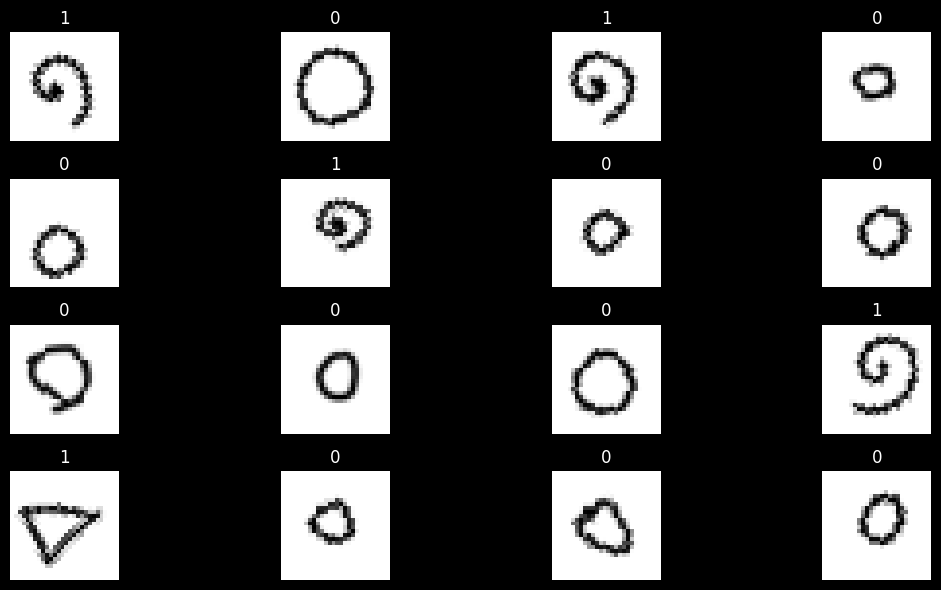

</details>

train_size: 3105, test_size: 777
📃 Thai-handwriting-number.appspot.com Dataset:
	Number of images in class 0: 388
	Number of images in class 1: 389
	Number of images in class 2: 389
	Number of images in class 3: 388
	Number of images in class 4: 388
	Number of images in class 5: 388
	Number of images in class 6: 388
	Number of images in class 7: 388
	Number of images in class 8: 388
	Number of images in class 9: 388
	Number of samples: 3882
----------------------------------------------------------------------------------------------------
📃Train Dataset:
	Number of images in class 0: 324
	Number of images in class 1: 311
	Number of images in class 2: 321
	Number of images in class 3: 316
	Number of images in class 4: 306
	Number of images in class 5: 312
	Number of images in class 6: 302
	Number of images in class 7: 304
	Number of images in class 8: 306
	Number of images in class 9: 303
	Number of training samples: 3105
----------------------------------------------------------------

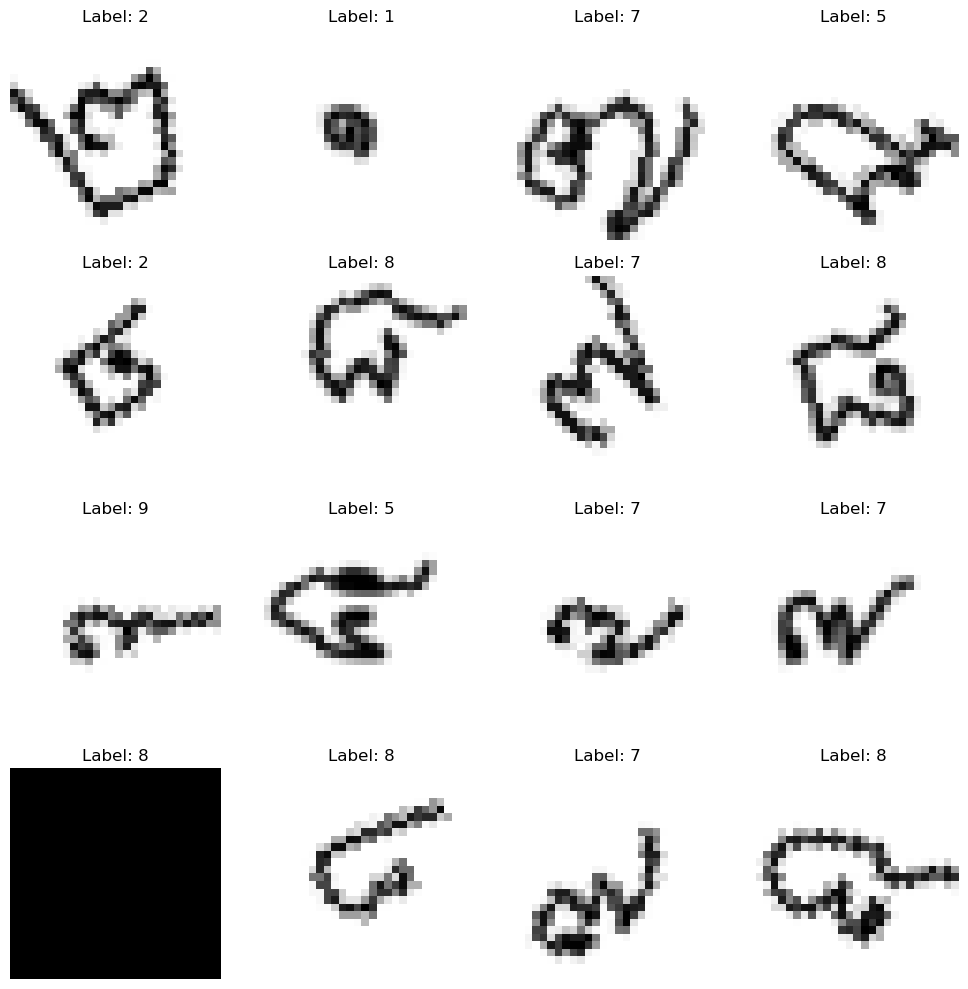


📃Test Dataset:
	Number of images in class 0: 64
	Number of images in class 1: 78
	Number of images in class 2: 68
	Number of images in class 3: 72
	Number of images in class 4: 82
	Number of images in class 5: 76
	Number of images in class 6: 86
	Number of images in class 7: 84
	Number of images in class 8: 82
	Number of images in class 9: 85
	Number of testing samples: 777
Batch Shape (Test): torch.Size([32, 1, 28, 28]), Labels Shape (Test): torch.Size([32])


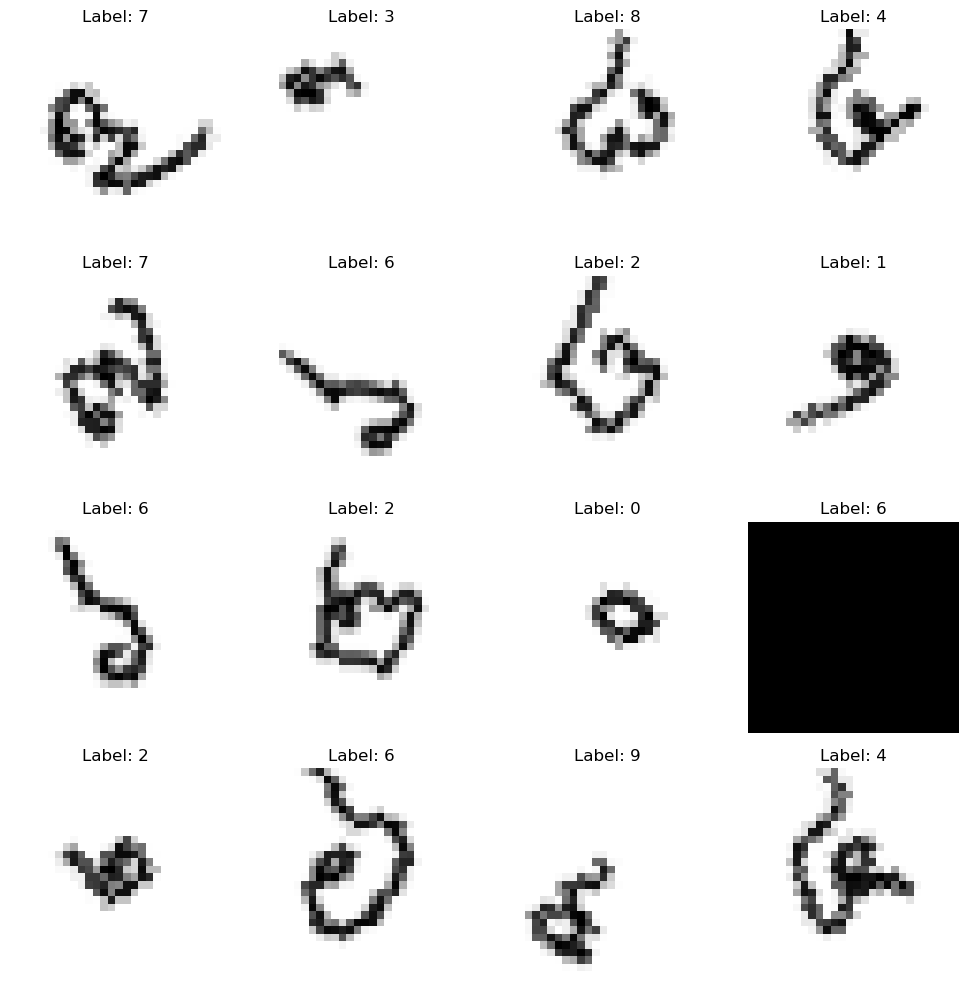

----------------------------------------------------------------------------------------------------


In [20]:
### START CODE HERE ###
dataset_path = os.path.join('Lab7_2_Thai-Handwriting-Number_Dataset', 'thai-handwriting-number.appspot.com')
dataset_path = os.path.abspath(dataset_path)

dataset = get_dataset(dataset_path)

dataset_classes = dataset.classes  # e.g., ['o', '๑', '๒']
class_names = list(range(len(dataset_classes))) # e.g., [0, 1, 2]

train_loader, test_loader = load_data(dataset_path,class_names)

# Get a batch of images
# data_iter = iter(train_loader)
# batch, labels = next(data_iter)

print_dataset_info(dataset_path, dataset, train_loader, test_loader)

# imshow_grid(batch, labels, class_names)
### END CODE HERE ###

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


In [8]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) # 1 CH: Grayscale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Initialize the feature maps and layer names list
        self.feature_maps = []
        self.layer_names = []

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("conv1 + ReLU")
        
        x = nn.functional.max_pool2d(x, 2)
        self.feature_maps.append(x.detach())
        self.layer_names.append("max pool 1")

        x = nn.functional.relu(self.conv2(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("conv2 + ReLU")
        
        x = nn.functional.max_pool2d(x, 2)
        self.feature_maps.append(x.detach())
        self.layer_names.append("max pool 2")

        x = x.view(-1, 16 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("fc1 + ReLU")
        
        x = nn.functional.relu(self.fc2(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("fc2 + ReLU")
        
        x = self.fc3(x)
        self.feature_maps.append(x.detach())
        self.layer_names.append("fc3(output)")
        return x
### END CODE HERE ###



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [9]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch.optim as optim

In [10]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    ### START CODE HERE ###
    print("🤖Training on", device)
    model = model.to(device)

    # Initialize lists to store predictions and labels
    all_preds = []
    all_labels = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, gt)
            loss.backward()
            opt.step()
            total_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = total_train_loss / len(train_loader)

        # Testing phase
        model.eval()
        total_test_loss = 0
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')

        with torch.no_grad():
            for images, gt in test_bar:
                images, gt = images.to(device), gt.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, gt)
                total_test_loss += loss.item()
                
                # Store predictions and ground truth for confusion matrix
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(gt.cpu().numpy())
                
                test_bar.set_postfix(loss=loss.item())

        avg_test_loss = total_test_loss / len(test_loader)
        print(f'Summary for Epoch {epoch+1}/{epochs}:')
        print(f'    Train    avg_loss: {avg_train_loss}')
        print(f'    Test     avg_loss: {avg_test_loss}')

        # Save model at the last epoch
        if epoch == epochs - 1 and checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved at {checkpoint_path}')

    return all_preds, all_labels  # Return predictions and labels

    ### END CODE HERE ###


Use your `train()` function to train models.

In [80]:
### START CODE HERE ###
# # Initialize model, optimizer, and loss function
model = CustomLeNet()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
# all_preds, all_labels = train(model, opt, loss_fn, train_loader, test_loader, epochs=30, 
#                             checkpoint_path='CustomLeNet.pth', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

🤖Training on cuda


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.14batch/s, loss=2.1]


Summary for Epoch 1/30:
    Train    avg_loss: 2.2330307060358474
    Test     avg_loss: 2.0761773872375486


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.04batch/s, loss=2.14]


Summary for Epoch 2/30:
    Train    avg_loss: 1.8512263589975786
    Test     avg_loss: 1.6614070844650268


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.92batch/s, loss=2.44]


Summary for Epoch 3/30:
    Train    avg_loss: 1.5494944915479543
    Test     avg_loss: 1.4830877113342285


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.75batch/s, loss=1.81]


Summary for Epoch 4/30:
    Train    avg_loss: 1.360762605253531
    Test     avg_loss: 1.2982787346839906


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.15batch/s, loss=2.41]


Summary for Epoch 5/30:
    Train    avg_loss: 1.2351745269736465
    Test     avg_loss: 1.2231456422805786


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.92batch/s, loss=1.68]


Summary for Epoch 6/30:
    Train    avg_loss: 1.1308736034802027
    Test     avg_loss: 1.0920600891113281


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.78batch/s, loss=1.51]


Summary for Epoch 7/30:
    Train    avg_loss: 1.0747852179468895
    Test     avg_loss: 1.1269896912574768


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.44batch/s, loss=2.34]


Summary for Epoch 8/30:
    Train    avg_loss: 1.0374423228964513
    Test     avg_loss: 1.1240465593338014


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.74batch/s, loss=2.45]


Summary for Epoch 9/30:
    Train    avg_loss: 0.9700873162673445
    Test     avg_loss: 1.0096322989463806


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.53batch/s, loss=1.84]


Summary for Epoch 10/30:
    Train    avg_loss: 0.9068923168340508
    Test     avg_loss: 0.9791017818450928


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.75batch/s, loss=1.08]


Summary for Epoch 11/30:
    Train    avg_loss: 0.8965212760531173
    Test     avg_loss: 0.8990359711647034


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.40batch/s, loss=1.81]


Summary for Epoch 12/30:
    Train    avg_loss: 0.8673893693758516
    Test     avg_loss: 0.9142029094696045


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.06batch/s, loss=2.46]


Summary for Epoch 13/30:
    Train    avg_loss: 0.8472037128058776
    Test     avg_loss: 0.9369849050045014


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.37batch/s, loss=1.74]


Summary for Epoch 14/30:
    Train    avg_loss: 0.7991781777022786
    Test     avg_loss: 0.8788979268074035


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.34batch/s, loss=1.96]


Summary for Epoch 15/30:
    Train    avg_loss: 0.761751325154791
    Test     avg_loss: 0.8810375022888184


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.19batch/s, loss=2.2]


Summary for Epoch 16/30:
    Train    avg_loss: 0.7765994417119999
    Test     avg_loss: 0.9328285610675812


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.93batch/s, loss=1.78]


Summary for Epoch 17/30:
    Train    avg_loss: 0.768555720849913
    Test     avg_loss: 0.8998485672473907


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.28batch/s, loss=1.71]


Summary for Epoch 18/30:
    Train    avg_loss: 0.7111480451968252
    Test     avg_loss: 0.847899569272995


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.42batch/s, loss=1.87]


Summary for Epoch 19/30:
    Train    avg_loss: 0.682089778537653
    Test     avg_loss: 0.8713839077949523


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.40batch/s, loss=1.84]


Summary for Epoch 20/30:
    Train    avg_loss: 0.7057107626175394
    Test     avg_loss: 0.8417724967002869


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.34batch/s, loss=1.43]


Summary for Epoch 21/30:
    Train    avg_loss: 0.6995869319011666
    Test     avg_loss: 0.809936990737915


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.56batch/s, loss=1.4]


Summary for Epoch 22/30:
    Train    avg_loss: 0.646249441049841
    Test     avg_loss: 0.7908184587955475


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.67batch/s, loss=1.72]


Summary for Epoch 23/30:
    Train    avg_loss: 0.6310019195935099
    Test     avg_loss: 0.8457164585590362


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.57batch/s, loss=1.73]


Summary for Epoch 24/30:
    Train    avg_loss: 0.6051977833885015
    Test     avg_loss: 0.7592889165878296


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.15batch/s, loss=1.84]


Summary for Epoch 25/30:
    Train    avg_loss: 0.5836062181018749
    Test     avg_loss: 0.7863119089603424


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.46batch/s, loss=0.759]


Summary for Epoch 26/30:
    Train    avg_loss: 0.5810577312902528
    Test     avg_loss: 0.796162462234497


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.00batch/s, loss=1.99]


Summary for Epoch 27/30:
    Train    avg_loss: 0.5758790781350844
    Test     avg_loss: 0.7953210902214051


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.97batch/s, loss=0.786]


Summary for Epoch 28/30:
    Train    avg_loss: 0.5489574177297574
    Test     avg_loss: 0.722862245440483


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  8.76batch/s, loss=1.61]


Summary for Epoch 29/30:
    Train    avg_loss: 0.560168448759585
    Test     avg_loss: 0.8315360200405121


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.41batch/s, loss=0.924]


Summary for Epoch 30/30:
    Train    avg_loss: 0.5678517006679761
    Test     avg_loss: 0.7776234918832778
Model saved at CustomLeNet.pth


Try to load the weights into the model and the confusion matrix.

In [ ]:
%pip install seaborn

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [12]:
def evaluate_model(y_true, y_pred):
    """
    Evaluates the performance of a classification model.
    
    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    
    Returns:
    None
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Initializing Model with Pretrained Weights --------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68      2070
           1       0.72      0.69      0.71      2400
           2       0.72      0.71      0.72      2550
           3       0.72      0.74      0.73      2070
           4       0.65      0.59      0.62      2430
           5       0.68      0.68      0.68      2520
           6       0.76      0.69      0.72      2640
           7       0.72      0.71      0.71      2190
           8       0.71      0.63      0.67      2250
           9       0.65      0.69      0.67      2190

    accuracy                           0.69     23310
   macro avg       0.69      0.69      0.69     23310
weighted avg       0.69      0.69      0.69     23310



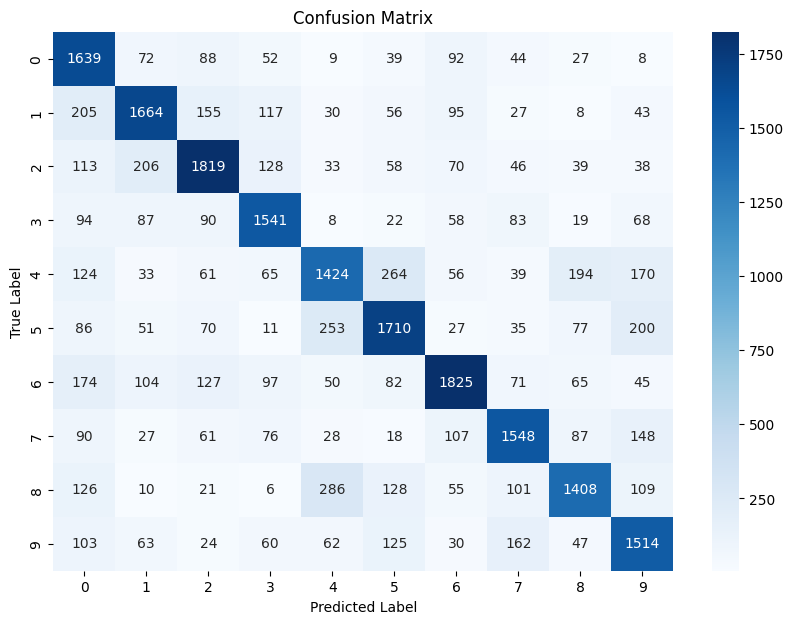

Evaluating Model with Test Loader --------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.87      0.70        69
           1       0.94      0.74      0.83        80
           2       0.73      0.85      0.78        85
           3       0.77      0.88      0.82        69
           4       0.71      0.64      0.68        81
           5       0.78      0.81      0.80        84
           6       0.90      0.69      0.78        88
           7       0.86      0.74      0.79        73
           8       0.78      0.61      0.69        75
           9       0.67      0.77      0.71        73

    accuracy                           0.76       777
   macro avg       0.77      0.76      0.76       777
weighted avg       0.78      0.76      0.76       777



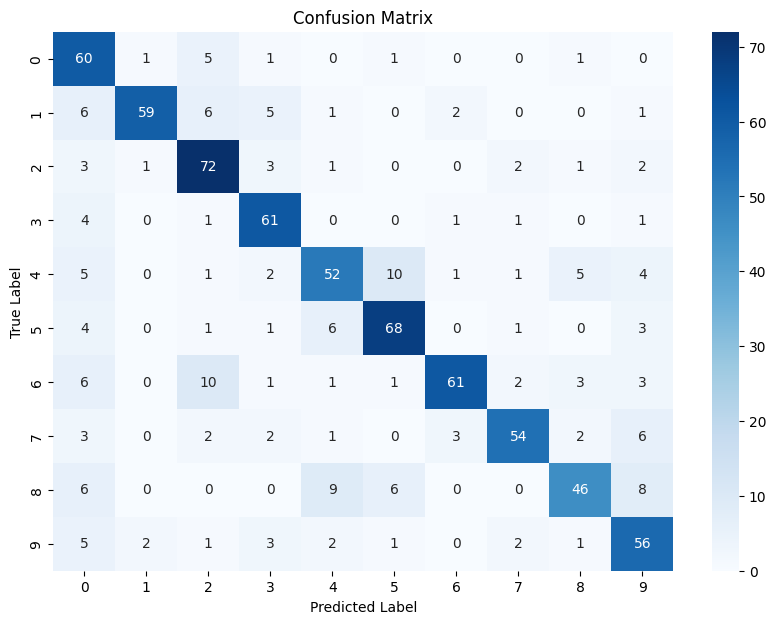

In [82]:
# ### START CODE HERE ###
# # Load the model weights
# checkpoint_path = 'CustomLeNet.pth' 
# model.load_state_dict(torch.load(checkpoint_path, weights_only=False))
# model.eval()  # Set the model to evaluation mode

# print('Initializing Model with Pretrained Weights','-'*50)
# evaluate_model(y_true=all_labels, y_pred=all_preds)

# print('Evaluating Model with Test Loader','-'*50)

# test_preds = []
# test_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         test_preds.extend(predicted.cpu().numpy())
#         test_labels.extend(labels.cpu().numpy())

# evaluate_model(y_true=test_labels, y_pred=test_preds)
# ### END CODE HERE ###

Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

In [72]:
def visualize_feature_maps(model, data_iter, layers=None, output_folder='feature_maps'):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    model.eval()  # Set model to evaluation mode
    
    # Clear previous feature maps and layer names
    model.feature_maps.clear()
    model.layer_names.clear()

    batch, labels = next(data_iter)

    # Prepare for visualization
    input_image = batch[0:1] # Get only first image
    ground_truth_label = labels[0].item()  # Get the ground truth label of the first image

    with torch.no_grad():
        output = model(input_image)  # Forward pass to capture feature maps

    print('\nInput Image:')
    if ground_truth_label is not None:
        print("Ground Truth Label:", ground_truth_label)
    
    # Show input image
    plt.figure(figsize=(4, 4))
    plt.imshow(input_image[0, 0].cpu(), cmap='gray')  # Assuming input is (1, 1, H, W)
    plt.axis('off')
    plt.title("Input Image")
    plt.savefig(os.path.join(output_folder, 'input_image.png'))
    plt.show()  # Show the plot in VS Code
    plt.close()  # Close the figure after saving

    print('Output Predict:')
    # Get probabilities and predicted class
    probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities
    predicted_classes = torch.argmax(probabilities, dim=1)  # Get predicted classes

    # Print probabilities and predicted classes
    probabilities_np = probabilities.cpu().numpy()
    predicted_classes_np = predicted_classes.cpu().numpy()

    print("Model Output Probabilities:")
    for i, prob in enumerate(probabilities_np[0]):  # Use the first (and only) image in the batch
        print(f"\tClass {class_names[i]}: Probability = {prob:.5f}")  # Show class index and its probability

    print(f"Predicted Classes: {predicted_classes_np[0]}")

    # If no specific layers are provided, visualize all layers
    if layers is None:
        layers = range(len(model.feature_maps))

    # Visualize and save selected feature maps
    for i in layers:
        if i < len(model.feature_maps):
            feature_map = model.feature_maps[i]
            if feature_map.dim() == 4:  # For convolutional layers
                num_feature_maps = feature_map.shape[1]
                fig, axes = plt.subplots(1, num_feature_maps, figsize=(num_feature_maps * 2, 2))
                fig.suptitle(f'Feature Maps from {model.layer_names[i]}', fontsize=16)

                for j in range(num_feature_maps):
                    axes[j].imshow(feature_map[0, j].cpu(), cmap='gray')
                    axes[j].axis('off')

                plt.tight_layout()  # Adjust layout to prevent clipping
                plt.savefig(os.path.join(output_folder, f'feature_map_layer_{i + 1}.png'))
                plt.show()  # Show the plot in VS Code
                plt.close(fig)  # Close the figure after saving
            elif feature_map.dim() == 2:  # For fully connected layers
                plt.figure(figsize=(10, 1))
                plt.title(f'Output from {model.layer_names[i]}')
                plt.imshow(feature_map.cpu().numpy().flatten()[None, :], aspect='auto', cmap='gray')
                plt.axis('off')
                plt.tight_layout()  # Adjust layout to prevent clipping
                plt.savefig(os.path.join(output_folder, f'feature_map_layer_{i + 1}.png'))
                plt.show()  # Show the plot in VS Code
                plt.close()  # Close the figure after saving

Captured Feature Maps:
Layer 1 (conv1 + ReLU)	:	torch.Size([32, 6, 24, 24])
Layer 2 (max pool 1)	:	torch.Size([32, 6, 12, 12])
Layer 3 (conv2 + ReLU)	:	torch.Size([32, 16, 8, 8])
Layer 4 (max pool 2)	:	torch.Size([32, 16, 4, 4])
Layer 5 (fc1 + ReLU)	:	torch.Size([32, 120])
Layer 6 (fc2 + ReLU)	:	torch.Size([32, 84])
Layer 7 (fc3(output))	:	torch.Size([32, 10])

Input Image:
Ground Truth Label: 7


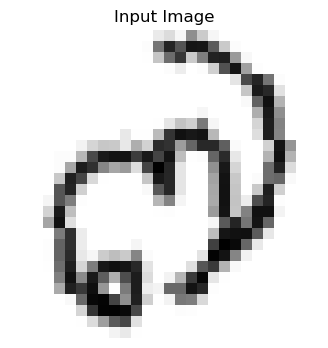

Output Predict:
Model Output Probabilities:
	Class 0: Probability = 0.00025
	Class 1: Probability = 0.00085
	Class 2: Probability = 0.04625
	Class 3: Probability = 0.01867
	Class 4: Probability = 0.07376
	Class 5: Probability = 0.02213
	Class 6: Probability = 0.04880
	Class 7: Probability = 0.77296
	Class 8: Probability = 0.00886
	Class 9: Probability = 0.00749
Predicted Classes: 7


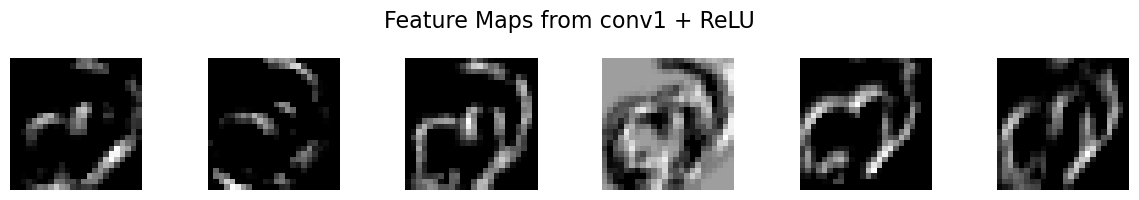

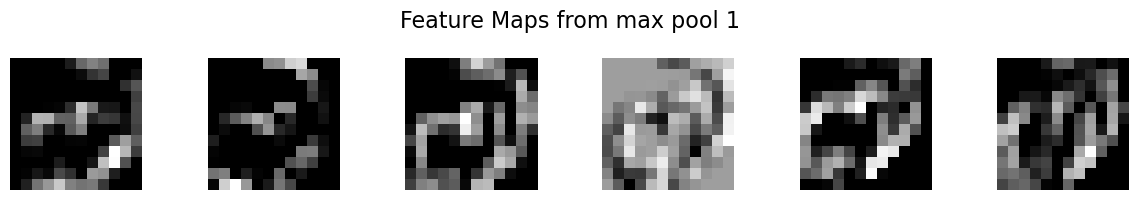

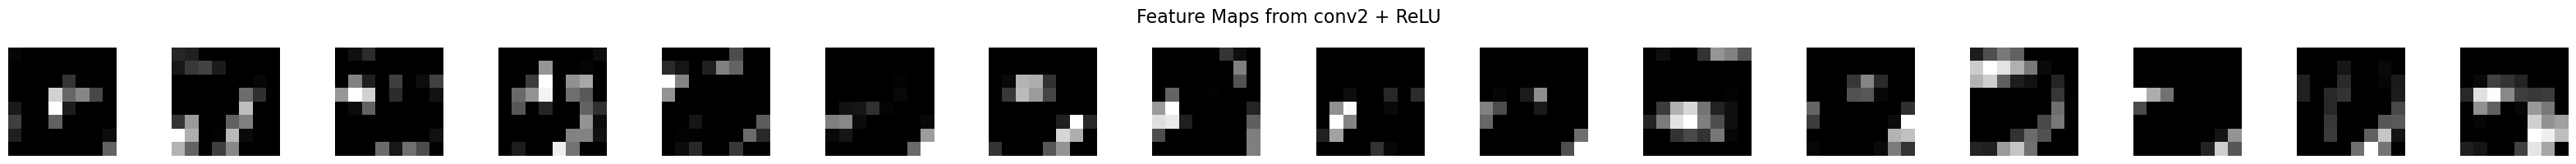

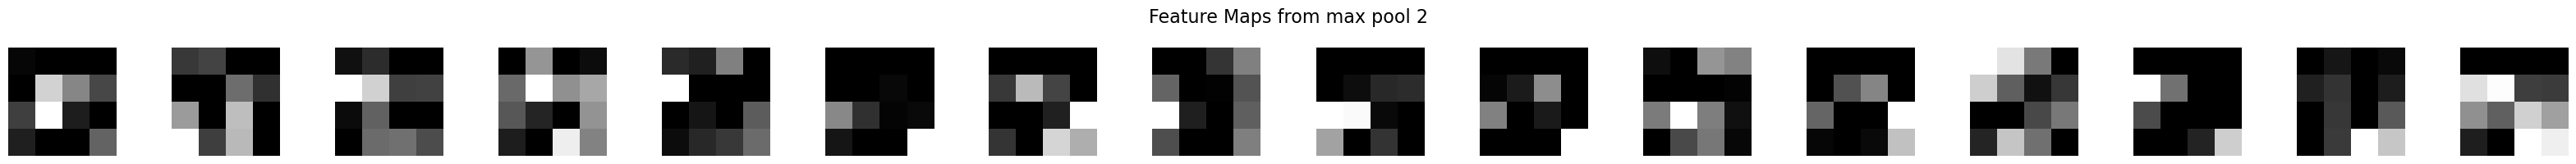

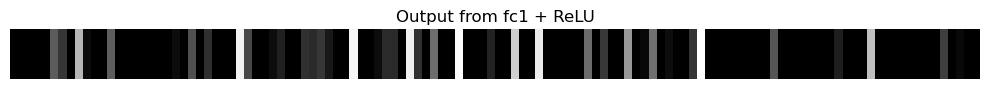

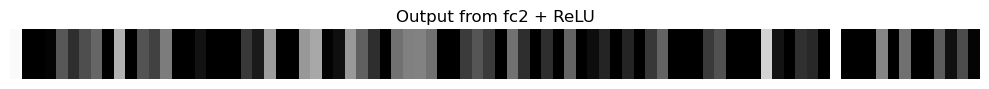

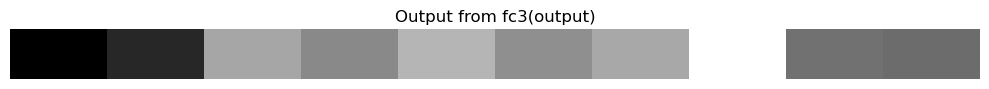

In [73]:
### START CODE HERE ###
# Set checkpoint path
checkpoint_path = 'CustomLeNet.pth' 

# Create model instance
model = CustomLeNet()

# Load model weights with map_location to CPU
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Forward pass to print feature maps
_ = model(batch)  # This will print shapes of feature maps

# Access and print feature maps
feature_maps = model.feature_maps
print("Captured Feature Maps:")
for i, (name, fmap) in enumerate(zip(model.layer_names, model.feature_maps)):
    print(f"Layer {i + 1} ({name})\t:\t{fmap.shape}")

# Get a batch from the data loader
data_iter = iter(train_loader)
# batch, labels = next(data_iter)

layers_to_visualize = None
visualize_feature_maps(model, data_iter, layers=layers_to_visualize, output_folder='feature_maps')
### END CODE HERE ###

---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.


---
# Answers
1. การระบุ 3 คลาสที่มีคะแนน F1 ต่ำที่สุด, วิเคราะห์พฤติกรรมของโมเดล และวิเคราะห์ feature maps
- ระบุ 3 คลาสที่มีคะแนน F1 ต่ำที่สุด:

In [92]:
from sklearn.metrics import f1_score

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
# Set random seed for Python's built-in random library
import random
random.seed(seed)

# Prepare true labels and predictions
y_true = []  # True labels
y_pred = []  # Model predictions

# Set the model to evaluation mode
model.eval()

# Perform predictions using the test_loader
for inputs, labels in test_loader:  # Assuming there's a data loader for the test dataset
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate F1 scores for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Get the indices of the 3 classes with the lowest F1 scores
worst_classes_indices = np.argsort(f1_scores)[:3]
worst_classes = [class_names[i] for i in worst_classes_indices]  # Get class names

# Display the class names along with their F1 scores
print("Top 3 classes with the lowest F1 scores:")
for i in worst_classes_indices:
    print(f"Class: {class_names[i]}, F1 Score: {f1_scores[i]:.4f}")


Top 3 classes with the lowest F1 scores:
Class: 0, F1 Score: 0.7216
Class: 8, F1 Score: 0.7344
Class: 4, F1 Score: 0.7368


- วิเคราะห์พฤติกรรมของโมเดล: ทำการวิเคราะห์ภาพที่ถูกคาดการณ์ผิดพลาดจากแต่ละคลาสที่มีคะแนน F1 ต่ำ เพื่อดูว่ามีลักษณะอะไรที่ทำให้โมเดลเกิดความสับสน:

Misclassified images for class: 0


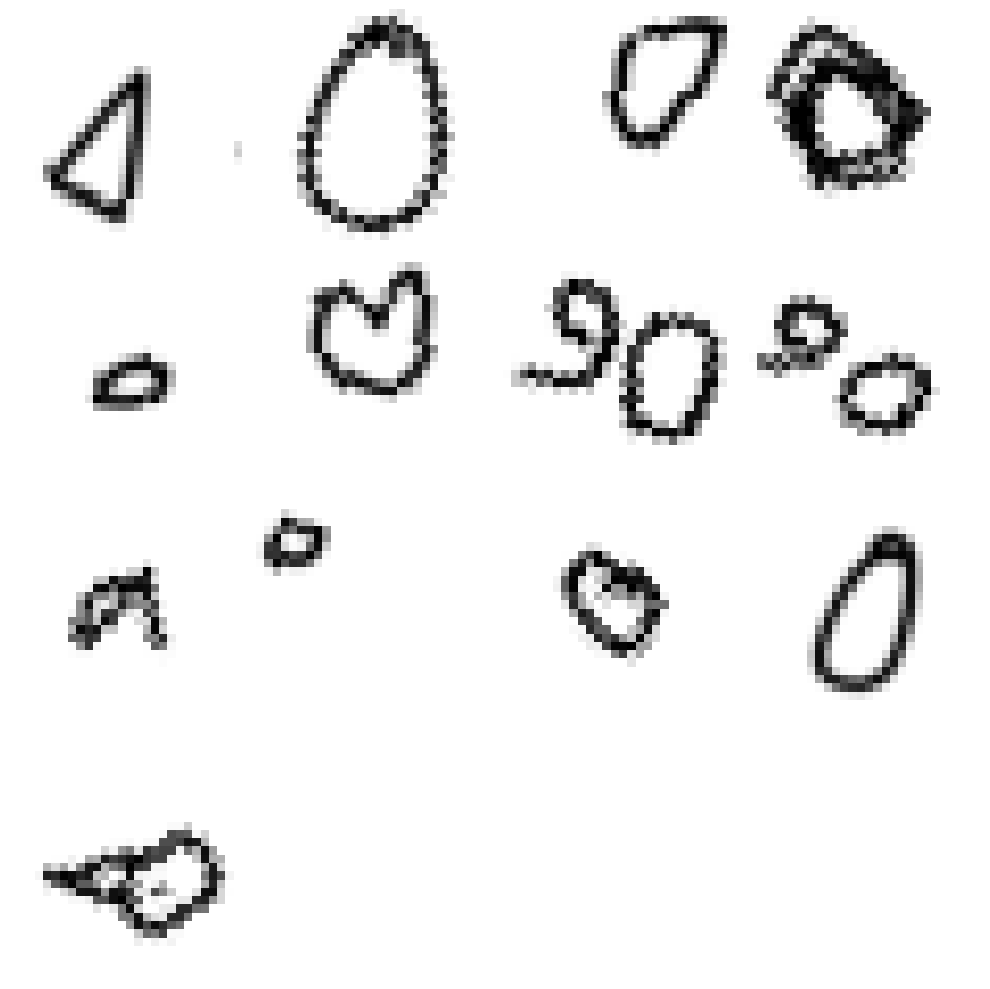

Misclassified images for class: 4


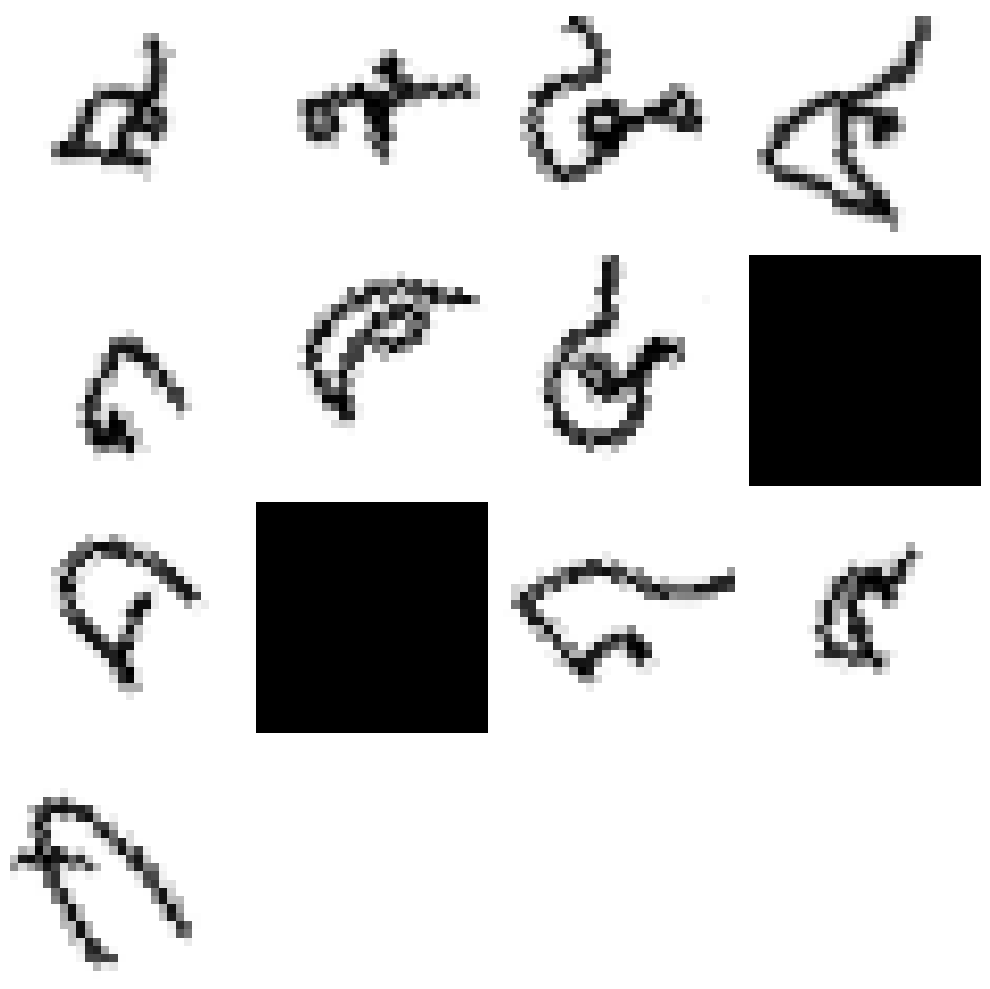

Misclassified images for class: 8


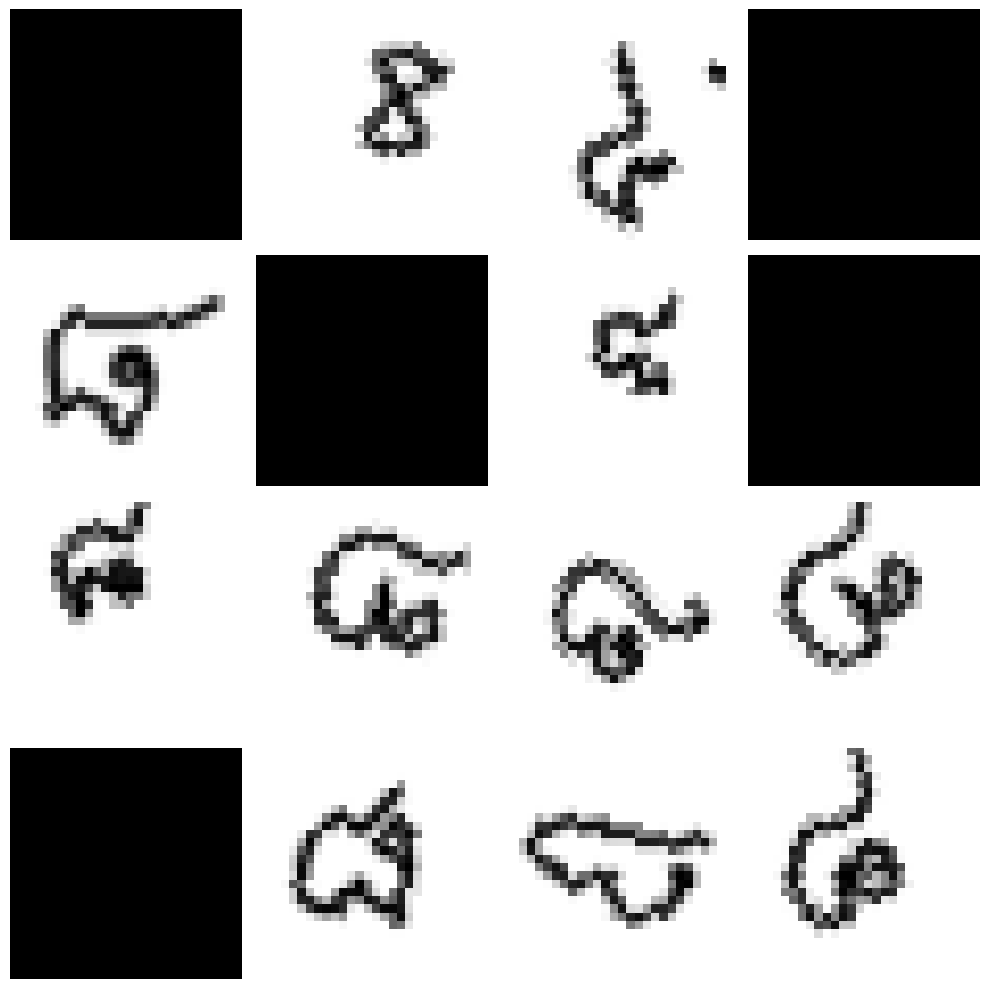

In [133]:
# Dictionary to hold misclassified images
misclassified_images = {class_name: [] for class_name in worst_classes}

# Collect misclassified images
for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    for i in range(len(labels)):
        label = labels[i].item()  # Convert tensor to an integer
        predicted_label = predicted[i].item()  # Convert tensor to an integer
        
        # Check if the true label is in worst classes and if the prediction is wrong
        if label in worst_classes_indices and predicted_label != label:
            class_name = class_names[label]  # Get the class name from the label index
            misclassified_images[class_name].append((inputs[i], label))  # Store misclassified images with their labels


# Display misclassified images for each worst class
for class_name in worst_classes:
    if misclassified_images[class_name]:  # Check if there are misclassified images
        print(f"Misclassified images for class: {class_name}")
        
        num_images = len(misclassified_images[class_name])
        num_cols = 4
        num_rows = 4

        plt.figure(figsize=(10, 10)) 
        for idx in range(min(num_images, num_rows * num_cols)): 
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            ax.imshow(misclassified_images[class_name][idx][0].cpu().squeeze(), cmap='gray')  # Access the image
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()


- วิเคราะห์ feature map: ทำการวิเคราะห์ feature map ของภาพที่ถูกทำนายผิดในแต่ละคลาสและเปรียบเทียบกับฟีเจอร์แมพของภาพที่ถูกทำนายถูกในคลาสเดียวกัน:

self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)


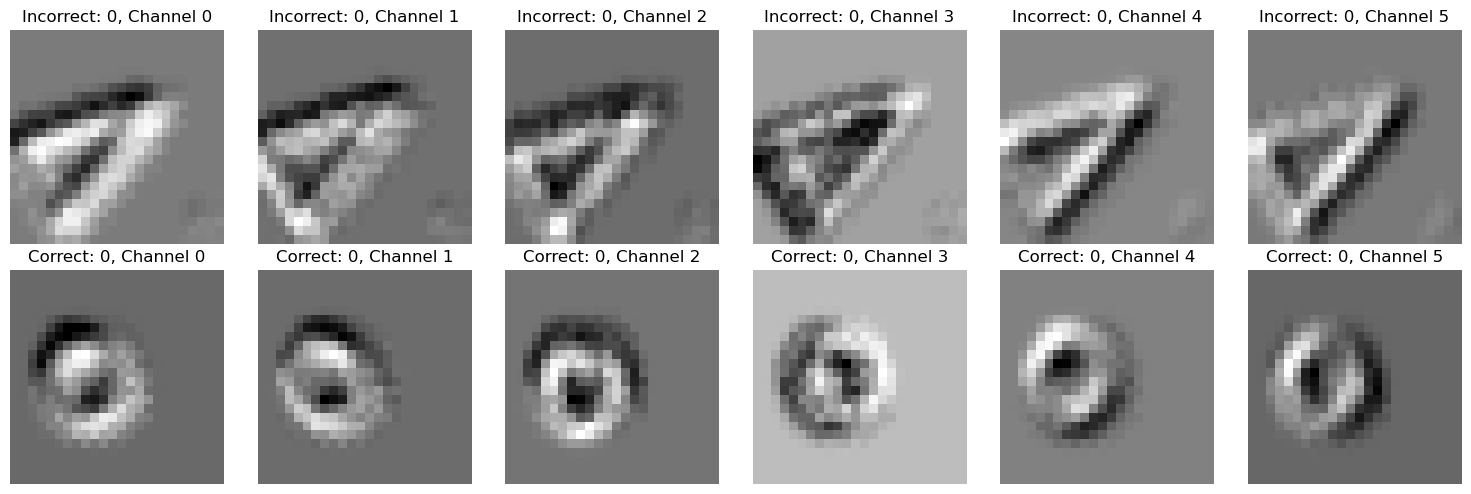

self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)


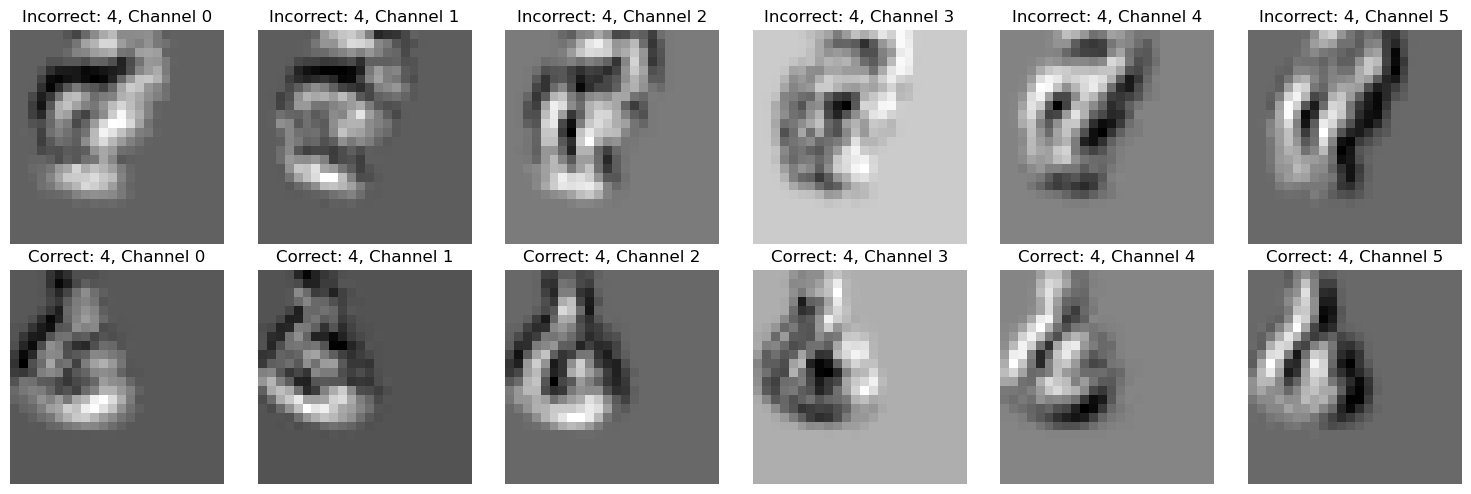

self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)


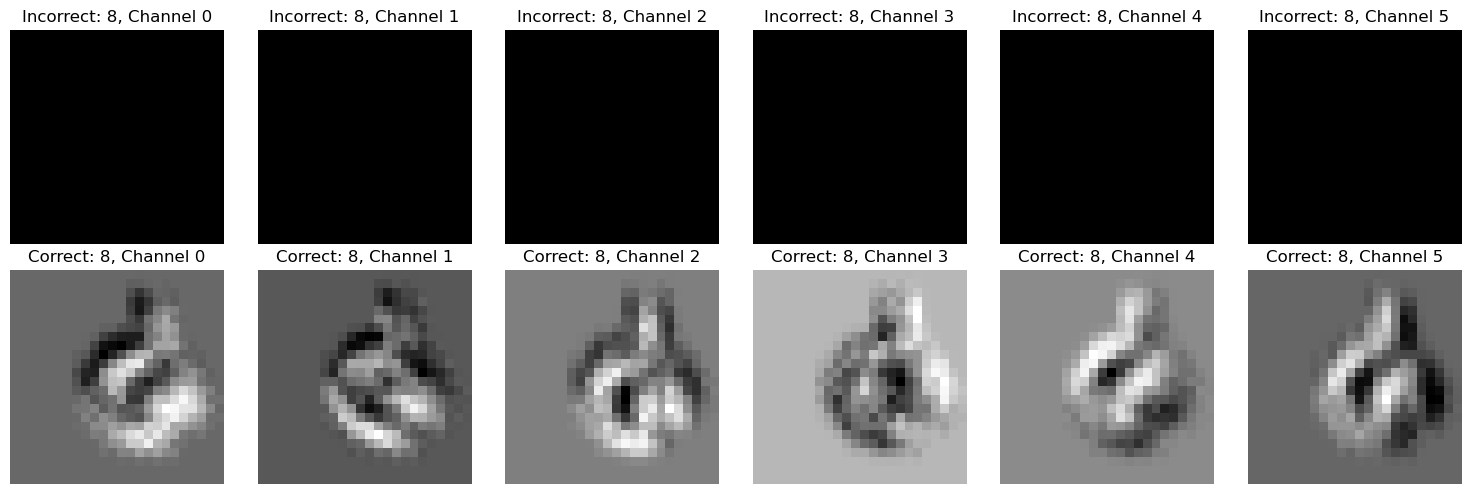

In [144]:
import torch
import matplotlib.pyplot as plt

# Function to get feature maps from a specific layer
def get_feature_map(model, input_tensor, layer_name):
    feature_map = None

    def hook_fn(module, input, output):
        nonlocal feature_map
        feature_map = output.detach()  # Detach to avoid tracking gradients

    # Register a hook on the desired layer
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_tensor.unsqueeze(0))  # Add batch dimension

    hook.remove()  # Remove hook after getting the output
    return feature_map

# Dictionary to hold misclassified images
misclassified_images = {class_name: [] for class_name in worst_classes}
correct_images_dict = {class_name: [] for class_name in class_names}

# Collect misclassified images and correctly classified images
for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(labels)):
        label = labels[i].item()  # True label
        predicted_label = predicted[i].item()  # Model's prediction

        if label in worst_classes_indices:
            if predicted_label != label:
                class_name = class_names[label]
                misclassified_images[class_name].append((inputs[i], label))  # Store as (image, label)
            else:
                class_name = class_names[label]
                correct_images_dict[class_name].append(inputs[i])  # Store correctly classified images

# Analyze feature maps for each worst class
for class_name in worst_classes:
    incorrect_images = misclassified_images[class_name]  # List of (image, label) tuples
    correct_images = correct_images_dict[class_name]  # List of correctly classified images

    if incorrect_images and correct_images:
        incorrect_image, incorrect_label = incorrect_images[0]  # Get first incorrectly classified image
        correct_image = correct_images[0]  # Get first correctly classified image

        # Get feature maps for both images
        layer_name = 'conv1'  # Replace with your actual layer name
        incorrect_feature_map = get_feature_map(model, incorrect_image, layer_name)
        correct_feature_map = get_feature_map(model, correct_image, layer_name)

        # Visualize feature maps
        num_channels = incorrect_feature_map.shape[1]  # Number of channels
        print("self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)")
        fig, axes = plt.subplots(2, num_channels, figsize=(15, 5))

        # Plot incorrect image feature maps
        for i in range(num_channels):
            axes[0, i].imshow(incorrect_feature_map[0, i].cpu().numpy(), cmap='gray')
            axes[0, i].set_title(f'Incorrect: {class_name}, Channel {i}')
            axes[0, i].axis('off')

        # Plot correct image feature maps
        for i in range(num_channels):
            axes[1, i].imshow(correct_feature_map[0, i].cpu().numpy(), cmap='gray')
            axes[1, i].set_title(f'Correct: {class_name}, Channel {i}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()


---
2. ไม่เสมอไป ความลึกของโมเดลเป็นเพียงหนึ่งในหลายปัจจัยที่ส่งผลต่อประสิทธิภาพของโมเดล การพิจารณาปัจจัยอื่น ๆ เช่น overfitting, เวลาฝึกอบรม, ความซับซ้อนของข้อมูล และความจุของโมเดล ก็มีความสำคัญด้วยเช่นกัน

    **ปัจจัยที่มีผลต่อประสิทธิภาพของโมเดล**

    - **Overfitting:** โมเดลที่ลึกเกินไปอาจมีแนวโน้มที่จะ overfit ซึ่งหมายถึงการเรียนรู้รูปแบบที่ซับซ้อนเกินไปจนไม่สามารถสรุปข้อมูลใหม่ได้อย่างถูกต้อง
    - **เวลาฝึกอบรม:** โมเดลที่ลึกขึ้นมักใช้เวลานานในการฝึกอบรม ซึ่งอาจไม่เหมาะสำหรับแอปพลิเคชันที่ต้องการผลลัพธ์อย่างรวดเร็ว
    - **ความซับซ้อนของข้อมูล:** สำหรับข้อมูลที่ไม่ซับซ้อนมาก โมเดลที่ตื้นกว่าก็อาจให้ประสิทธิภาพที่ดีเท่ากับโมเดลที่ลึกกว่า
    - **ความจุของโมเดล:** ความจุของโมเดลหมายถึงความสามารถในการเรียนรู้รูปแบบที่ซับซ้อน หากโมเดลมีขนาดเล็กเกินไป อาจไม่สามารถเรียนรู้รูปแบบที่ซับซ้อนของข้อมูลได้

    **ตัวอย่างจากการทดลอง**

    - **ImageNet:** การทดลองกับชุดข้อมูล ImageNet แสดงให้เห็นว่าโมเดลที่ลึกขึ้น เช่น ResNet และ DenseNet สามารถบรรลุประสิทธิภาพที่ดีขึ้น แต่โมเดลที่ลึกเกินไปก็อาจเกิด overfitting ได้
    - **Natural Language Processing:** ในงาน NLP โมเดลที่ลึกขึ้น เช่น Transformer ก็สามารถปรับปรุงประสิทธิภาพได้อย่างมาก แต่ก็ยังต้องคำนึงถึงปัจจัยอื่น ๆ เช่นความซับซ้อนของงานและจำนวนข้อมูลที่มี
